# Etapa 1: Coleta e Exploração de Dados (20%)

## Objetivo
Realizar análise exploratória completa dos dados de visualizações de páginas da Wikipedia, identificando padrões, tendências e características da série temporal.

## Fonte dos Dados
- **Dataset**: Web Traffic Time Series Forecasting (Kaggle)
- **Período**: Julho 2015 - Dezembro 2016
- **Frequência**: Diária
- **Variável**: Número de visualizações de páginas

In [1]:
# Instalação de bibliotecas necessárias
# pip install pandas numpy matplotlib seaborn plotly statsmodels scipy scikit-learn --break-system-packages -q

In [2]:
# Importação de bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Configurações de visualização
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✓ Bibliotecas importadas com sucesso!")

✓ Bibliotecas importadas com sucesso!


## 1. Aquisição dos Dados

In [ ]:
# Carregar dados
df_raw = pd.read_csv('train_1_sample.csv')

print(f"Dimensões do dataset: {df_raw.shape}")
print(f"Número de páginas: {df_raw.shape[0]}")
print(f"Número de datas: {df_raw.shape[1] - 1}")

# Visualizar primeiras linhas
df_raw.head()

Dimensões do dataset: (9, 551)
Número de páginas: 9
Número de datas: 550


,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32,63,15,26,14,20,22,19,18,20
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17,42,28,15,9,30,52,45,26,20
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3,1,1,7,4,4,6,3,4,17
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32,10,26,27,16,11,17,19,10,11
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48,9,25,13,3,11,27,13,36,10


In [4]:
# Transformar de formato wide para long (série temporal)
df_melted = df_raw.melt(id_vars=['Page'], var_name='Date', value_name='Views')

# Converter data para datetime
df_melted['Date'] = pd.to_datetime(df_melted['Date'])

# Extrair informações da coluna Page
df_melted[['Page_Name', 'Project', 'Access', 'Agent']] = df_melted['Page'].str.rsplit('_', n=3, expand=True)

print("\nDataset transformado:")
print(df_melted.head())
print(f"\nPeríodo: {df_melted['Date'].min()} até {df_melted['Date'].max()}")
print(f"Total de dias: {df_melted['Date'].nunique()}")


Dataset transformado:
                                                Page       Date  Views  \
0            2NE1_zh.wikipedia.org_all-access_spider 2015-07-01   18.0   
1             2PM_zh.wikipedia.org_all-access_spider 2015-07-01   11.0   
2              3C_zh.wikipedia.org_all-access_spider 2015-07-01    1.0   
3         4minute_zh.wikipedia.org_all-access_spider 2015-07-01   35.0   
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s... 2015-07-01    NaN   

          Page_Name           Project      Access   Agent  
0              2NE1  zh.wikipedia.org  all-access  spider  
1               2PM  zh.wikipedia.org  all-access  spider  
2                3C  zh.wikipedia.org  all-access  spider  
3           4minute  zh.wikipedia.org  all-access  spider  
4  52_Hz_I_Love_You  zh.wikipedia.org  all-access  spider  

Período: 2015-07-01 00:00:00 até 2016-12-31 00:00:00
Total de dias: 550


## 2. Verificação de Integridade dos Dados

In [5]:
# Informações gerais
print("=" * 60)
print("INFORMAÇÕES DO DATASET")
print("=" * 60)
df_melted.info()

print("\n" + "=" * 60)
print("VALORES AUSENTES")
print("=" * 60)
missing = df_melted.isnull().sum()
missing_percent = (missing / len(df_melted)) * 100
missing_df = pd.DataFrame({
    'Coluna': missing.index,
    'Missing': missing.values,
    'Percentual': missing_percent.values
})
print(missing_df[missing_df['Missing'] > 0])

INFORMAÇÕES DO DATASET
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4950 entries, 0 to 4949
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Page       4950 non-null   object        
 1   Date       4950 non-null   datetime64[ns]
 2   Views      4294 non-null   float64       
 3   Page_Name  4950 non-null   object        
 4   Project    4950 non-null   object        
 5   Access     4950 non-null   object        
 6   Agent      4950 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 270.8+ KB

VALORES AUSENTES
  Coluna  Missing  Percentual
2  Views      656   13.252525


Valores ausentes por página:
Page
2NE1_zh.wikipedia.org_all-access_spider                  0
2PM_zh.wikipedia.org_all-access_spider                   0
3C_zh.wikipedia.org_all-access_spider                    0
4minute_zh.wikipedia.org_all-access_spider               0
52_Hz_I_Love_You_zh.wikipedia.org_all-access_spider    291
5566_zh.wikipedia.org_all-access_spider                  0
91Days_zh.wikipedia.org_all-access_spider              365
A'N'D_zh.wikipedia.org_all-access_spider                 0
AKB48_zh.wikipedia.org_all-access_spider                 0
Name: Views, dtype: int64


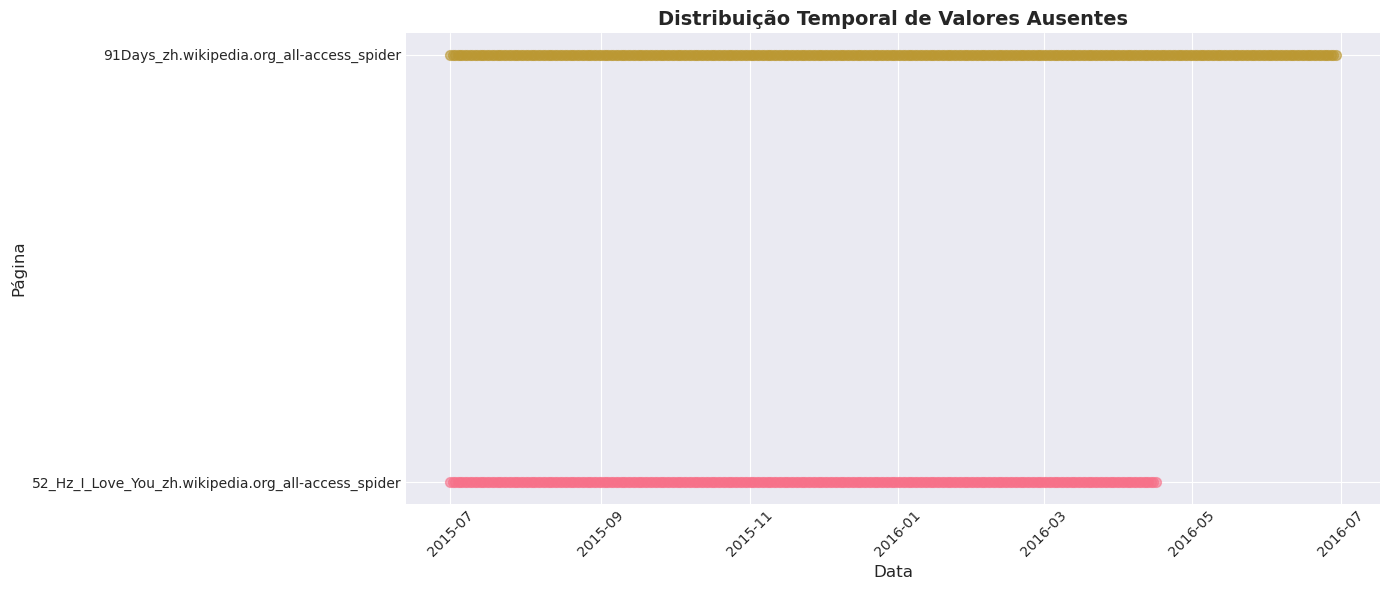

In [6]:
# Análise de valores ausentes nas visualizações
print("Valores ausentes por página:")
missing_by_page = df_melted.groupby('Page')['Views'].apply(lambda x: x.isnull().sum())
print(missing_by_page)

# Visualizar padrão de valores ausentes
fig, ax = plt.subplots(figsize=(14, 6))
for page in df_melted['Page'].unique():
    page_data = df_melted[df_melted['Page'] == page].sort_values('Date')
    missing_mask = page_data['Views'].isnull()
    if missing_mask.any():
        ax.scatter(page_data[missing_mask]['Date'], 
                  [page] * missing_mask.sum(),
                  alpha=0.6, s=50)

ax.set_xlabel('Data', fontsize=12)
ax.set_ylabel('Página', fontsize=12)
ax.set_title('Distribuição Temporal de Valores Ausentes', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [7]:
# Verificar duplicatas
duplicates = df_melted.duplicated(subset=['Page', 'Date']).sum()
print(f"\nNúmero de registros duplicados: {duplicates}")

# Verificar consistência das datas
print("\nVerificação de continuidade das datas:")
for page in df_melted['Page'].unique()[:3]:  # Verificar primeiras 3 páginas
    page_dates = df_melted[df_melted['Page'] == page].sort_values('Date')['Date']
    date_diffs = page_dates.diff().dt.days.dropna().unique()
    print(f"  {page[:30]}...: diferenças entre datas = {date_diffs}")


Número de registros duplicados: 0

Verificação de continuidade das datas:
  2NE1_zh.wikipedia.org_all-acce...: diferenças entre datas = [1.]
  2PM_zh.wikipedia.org_all-acces...: diferenças entre datas = [1.]
  3C_zh.wikipedia.org_all-access...: diferenças entre datas = [1.]


## 3. Estatísticas Descritivas

In [8]:
# Estatísticas descritivas gerais
print("=" * 60)
print("ESTATÍSTICAS DESCRITIVAS DAS VISUALIZAÇÕES")
print("=" * 60)
print(df_melted['Views'].describe())

# Estatísticas por página
print("\n" + "=" * 60)
print("ESTATÍSTICAS POR PÁGINA")
print("=" * 60)
stats_by_page = df_melted.groupby('Page')['Views'].agg([
    'count', 'mean', 'median', 'std', 'min', 'max',
    ('cv', lambda x: x.std() / x.mean() if x.mean() != 0 else np.nan),  # Coeficiente de variação
    ('q25', lambda x: x.quantile(0.25)),
    ('q75', lambda x: x.quantile(0.75))
]).round(2)

print(stats_by_page)

ESTATÍSTICAS DESCRITIVAS DAS VISUALIZAÇÕES
count    4294.000000
mean       23.313228
std        31.139175
min         0.000000
25%         8.000000
50%        15.000000
75%        27.000000
max       621.000000
Name: Views, dtype: float64

ESTATÍSTICAS POR PÁGINA
                                                    count   mean  median  \
Page                                                                       
2NE1_zh.wikipedia.org_all-access_spider               550  21.76    16.0   
2PM_zh.wikipedia.org_all-access_spider                550  25.39    17.0   
3C_zh.wikipedia.org_all-access_spider                 550   5.20     4.0   
4minute_zh.wikipedia.org_all-access_spider            550  17.13    13.0   
52_Hz_I_Love_You_zh.wikipedia.org_all-access_sp...    259  10.28     5.0   
5566_zh.wikipedia.org_all-access_spider               550  16.41    13.5   
91Days_zh.wikipedia.org_all-access_spider             185  19.69    12.0   
A'N'D_zh.wikipedia.org_all-access_spider            

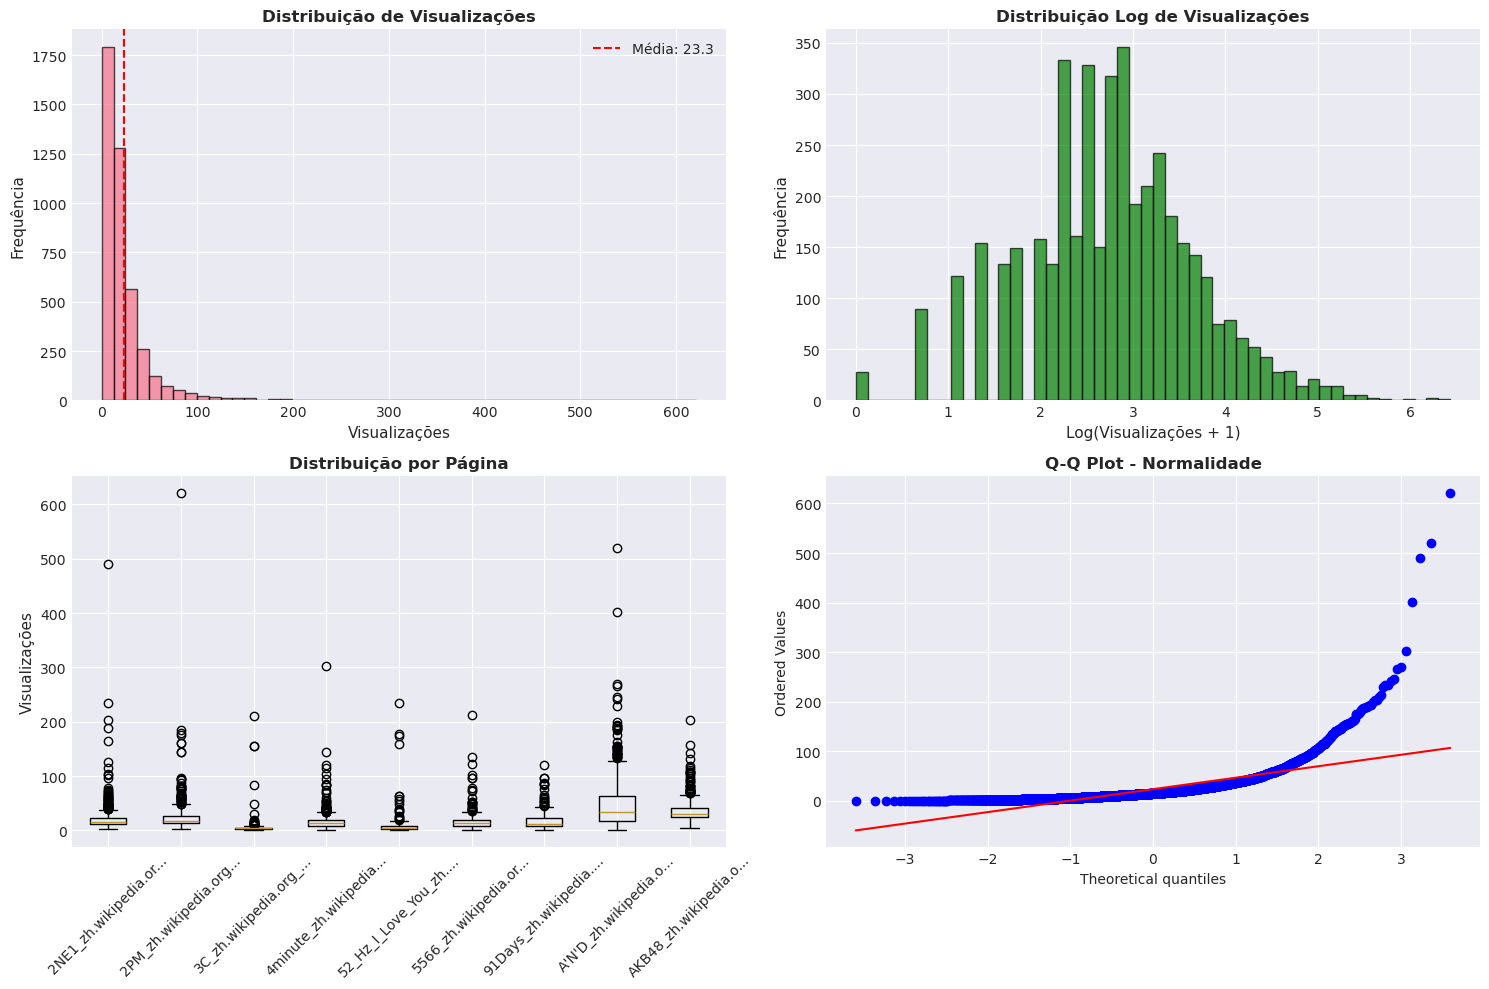


Teste de normalidade (D'Agostino): p-value = 0.000000
Conclusão: Dados NÃO seguem distribuição normal


In [9]:
# Visualização de distribuição das visualizações
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Histograma
axes[0, 0].hist(df_melted['Views'].dropna(), bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Visualizações', fontsize=11)
axes[0, 0].set_ylabel('Frequência', fontsize=11)
axes[0, 0].set_title('Distribuição de Visualizações', fontsize=12, fontweight='bold')
axes[0, 0].axvline(df_melted['Views'].mean(), color='red', linestyle='--', label=f'Média: {df_melted["Views"].mean():.1f}')
axes[0, 0].legend()

# Histograma log-scale
axes[0, 1].hist(np.log1p(df_melted['Views'].dropna()), bins=50, edgecolor='black', alpha=0.7, color='green')
axes[0, 1].set_xlabel('Log(Visualizações + 1)', fontsize=11)
axes[0, 1].set_ylabel('Frequência', fontsize=11)
axes[0, 1].set_title('Distribuição Log de Visualizações', fontsize=12, fontweight='bold')

# Boxplot
axes[1, 0].boxplot([df_melted[df_melted['Page'] == page]['Views'].dropna() 
                     for page in df_melted['Page'].unique()],
                    labels=[page[:20] + '...' for page in df_melted['Page'].unique()])
axes[1, 0].set_ylabel('Visualizações', fontsize=11)
axes[1, 0].set_title('Distribuição por Página', fontsize=12, fontweight='bold')
axes[1, 0].tick_params(axis='x', rotation=45)

# Q-Q Plot
stats.probplot(df_melted['Views'].dropna(), dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot - Normalidade', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Teste de normalidade
from scipy.stats import shapiro, normaltest
sample = df_melted['Views'].dropna().sample(min(5000, len(df_melted['Views'].dropna())))
stat, p_value = normaltest(sample)
print(f"\nTeste de normalidade (D'Agostino): p-value = {p_value:.6f}")
print(f"Conclusão: Dados {'seguem' if p_value > 0.05 else 'NÃO seguem'} distribuição normal")

## 4. Identificação de Outliers

In [10]:
# Método IQR (Interquartile Range)
def detect_outliers_iqr(data, column, multiplier=1.5):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

outliers, lower, upper = detect_outliers_iqr(df_melted.dropna(), 'Views')

print("=" * 60)
print("ANÁLISE DE OUTLIERS (Método IQR)")
print("=" * 60)
print(f"Limite inferior: {lower:.2f}")
print(f"Limite superior: {upper:.2f}")
print(f"Número de outliers: {len(outliers)} ({len(outliers)/len(df_melted)*100:.2f}%)")

# Outliers por página
print("\nOutliers por página:")
outliers_by_page = outliers.groupby('Page').size().sort_values(ascending=False)
print(outliers_by_page)

ANÁLISE DE OUTLIERS (Método IQR)
Limite inferior: -20.50
Limite superior: 55.50
Número de outliers: 339 (6.85%)

Outliers por página:
Page
A'N'D_zh.wikipedia.org_all-access_spider               165
AKB48_zh.wikipedia.org_all-access_spider                61
2PM_zh.wikipedia.org_all-access_spider                  39
2NE1_zh.wikipedia.org_all-access_spider                 27
4minute_zh.wikipedia.org_all-access_spider              14
91Days_zh.wikipedia.org_all-access_spider               12
5566_zh.wikipedia.org_all-access_spider                 10
52_Hz_I_Love_You_zh.wikipedia.org_all-access_spider      7
3C_zh.wikipedia.org_all-access_spider                    4
dtype: int64


## 5. Análise de Tendências e Padrões Temporais

In [11]:
# Visualização de séries temporais individuais
fig = go.Figure()

for page in df_melted['Page'].unique():
    page_data = df_melted[df_melted['Page'] == page].sort_values('Date')
    fig.add_trace(go.Scatter(
        x=page_data['Date'],
        y=page_data['Views'],
        mode='lines',
        name=page[:40],
        line=dict(width=2),
        opacity=0.8
    ))

fig.update_layout(
    title='Séries Temporais de Visualizações por Página',
    xaxis_title='Data',
    yaxis_title='Visualizações',
    hovermode='x unified',
    height=600,
    template='plotly_white'
)

fig.show()

In [12]:
# Análise de tendência (média móvel)
window_sizes = [7, 30, 90]  # Janelas de 7 dias, 30 dias e 90 dias

fig = make_subplots(
    rows=len(df_melted['Page'].unique()), cols=1,
    subplot_titles=[f'Tendência - {page[:40]}' for page in df_melted['Page'].unique()],
    vertical_spacing=0.08
)

for idx, page in enumerate(df_melted['Page'].unique(), 1):
    page_data = df_melted[df_melted['Page'] == page].sort_values('Date').copy()
    
    # Dados originais
    fig.add_trace(
        go.Scatter(x=page_data['Date'], y=page_data['Views'],
                  mode='lines', name='Original', line=dict(color='lightgray', width=1),
                  showlegend=(idx==1)),
        row=idx, col=1
    )
    
    # Médias móveis
    colors = ['blue', 'green', 'red']
    for window, color in zip(window_sizes, colors):
        page_data[f'MA_{window}'] = page_data['Views'].rolling(window=window, center=True).mean()
        fig.add_trace(
            go.Scatter(x=page_data['Date'], y=page_data[f'MA_{window}'],
                      mode='lines', name=f'MA {window}d',
                      line=dict(color=color, width=2),
                      showlegend=(idx==1)),
            row=idx, col=1
        )
    
    fig.update_yaxes(title_text="Views", row=idx, col=1)

fig.update_xaxes(title_text="Data", row=len(df_melted['Page'].unique()), col=1)
fig.update_layout(height=400*len(df_melted['Page'].unique()), 
                  title_text="Análise de Tendência com Médias Móveis",
                  showlegend=True)
fig.show()

In [13]:
# Adicionar features temporais
df_melted['Year'] = df_melted['Date'].dt.year
df_melted['Month'] = df_melted['Date'].dt.month
df_melted['DayOfWeek'] = df_melted['Date'].dt.dayofweek
df_melted['DayOfWeekName'] = df_melted['Date'].dt.day_name()
df_melted['Quarter'] = df_melted['Date'].dt.quarter
df_melted['WeekOfYear'] = df_melted['Date'].dt.isocalendar().week

print("Features temporais adicionadas:")
print(df_melted[['Date', 'Year', 'Month', 'DayOfWeek', 'DayOfWeekName', 'Quarter', 'WeekOfYear']].head())

Features temporais adicionadas:
        Date  Year  Month  DayOfWeek DayOfWeekName  Quarter  WeekOfYear
0 2015-07-01  2015      7          2     Wednesday        3          27
1 2015-07-01  2015      7          2     Wednesday        3          27
2 2015-07-01  2015      7          2     Wednesday        3          27
3 2015-07-01  2015      7          2     Wednesday        3          27
4 2015-07-01  2015      7          2     Wednesday        3          27


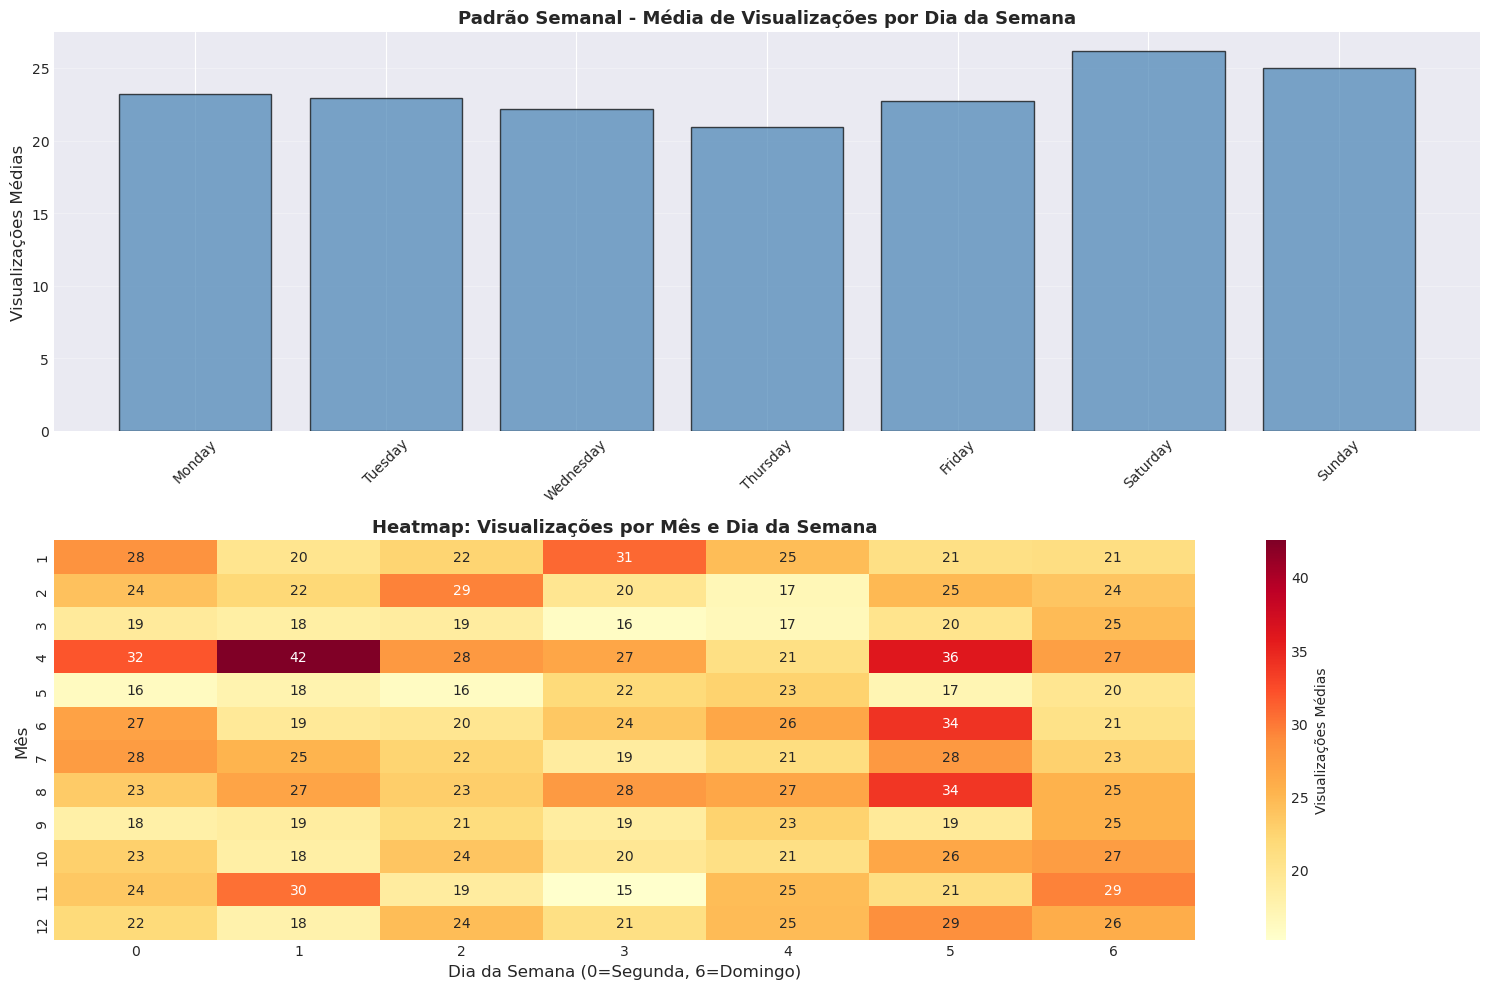


Estatísticas por dia da semana:
                    mean  median        std
DayOfWeekName                              
Monday         23.236453    15.0  28.373970
Tuesday        22.899836    14.0  38.420691
Wednesday      22.193182    15.0  26.759878
Thursday       20.969206    15.0  23.879446
Friday         22.755267    15.0  27.517528
Saturday       26.181524    15.0  40.448734
Sunday         24.970443    15.0  28.635684


In [14]:
# Análise de sazonalidade semanal
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Visualizações por dia da semana
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekly_pattern = df_melted.groupby('DayOfWeekName')['Views'].mean().reindex(day_order)

axes[0].bar(range(7), weekly_pattern.values, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].set_xticks(range(7))
axes[0].set_xticklabels(day_order, rotation=45)
axes[0].set_ylabel('Visualizações Médias', fontsize=12)
axes[0].set_title('Padrão Semanal - Média de Visualizações por Dia da Semana', 
                  fontsize=13, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Heatmap por dia da semana e mês
heatmap_data = df_melted.pivot_table(values='Views', index='Month', 
                                     columns='DayOfWeek', aggfunc='mean')
sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='YlOrRd', 
            cbar_kws={'label': 'Visualizações Médias'}, ax=axes[1])
axes[1].set_xlabel('Dia da Semana (0=Segunda, 6=Domingo)', fontsize=12)
axes[1].set_ylabel('Mês', fontsize=12)
axes[1].set_title('Heatmap: Visualizações por Mês e Dia da Semana', 
                  fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

# Estatísticas por dia da semana
print("\nEstatísticas por dia da semana:")
print(df_melted.groupby('DayOfWeekName')['Views'].agg(['mean', 'median', 'std']).reindex(day_order))

In [15]:
# Análise de sazonalidade mensal
monthly_pattern = df_melted.groupby(['Year', 'Month'])['Views'].agg(['mean', 'sum']).reset_index()
monthly_pattern['Date'] = pd.to_datetime(monthly_pattern[['Year', 'Month']].assign(day=1))

fig = make_subplots(
    rows=2, cols=1,
    subplot_titles=('Média Mensal de Visualizações', 'Total Mensal de Visualizações'),
    vertical_spacing=0.12
)

fig.add_trace(
    go.Scatter(x=monthly_pattern['Date'], y=monthly_pattern['mean'],
              mode='lines+markers', name='Média Mensal',
              line=dict(color='royalblue', width=3),
              marker=dict(size=8)),
    row=1, col=1
)

fig.add_trace(
    go.Bar(x=monthly_pattern['Date'], y=monthly_pattern['sum'],
           name='Total Mensal', marker_color='lightseagreen'),
    row=2, col=1
)

fig.update_xaxes(title_text="Mês", row=2, col=1)
fig.update_yaxes(title_text="Visualizações Médias", row=1, col=1)
fig.update_yaxes(title_text="Total de Visualizações", row=2, col=1)

fig.update_layout(height=700, showlegend=False, title_text="Análise Mensal")
fig.show()

print("\nEstatísticas mensais:")
print(monthly_pattern[['Month', 'mean', 'sum']])


Estatísticas mensais:
    Month       mean     sum
0       7  20.396313  4426.0
1       8  22.382488  4857.0
2       9  15.200000  3192.0
3      10  17.368664  3769.0
4      11  18.776190  3943.0
5      12  21.096774  4578.0
6       1  23.811060  5167.0
7       2  23.009852  4671.0
8       3  18.935484  4109.0
9       4  30.281250  6783.0
10      5  18.641129  4623.0
11      6  24.182573  5828.0
12      7  26.007168  7256.0
13      8  29.831541  8323.0
14      9  24.722222  6675.0
15     10  27.150538  7575.0
16     11  27.029630  7298.0
17     12  25.211470  7034.0


## 6. Decomposição da Série Temporal


DECOMPOSIÇÃO: 2NE1_zh.wikipedia.org_all-access_spider


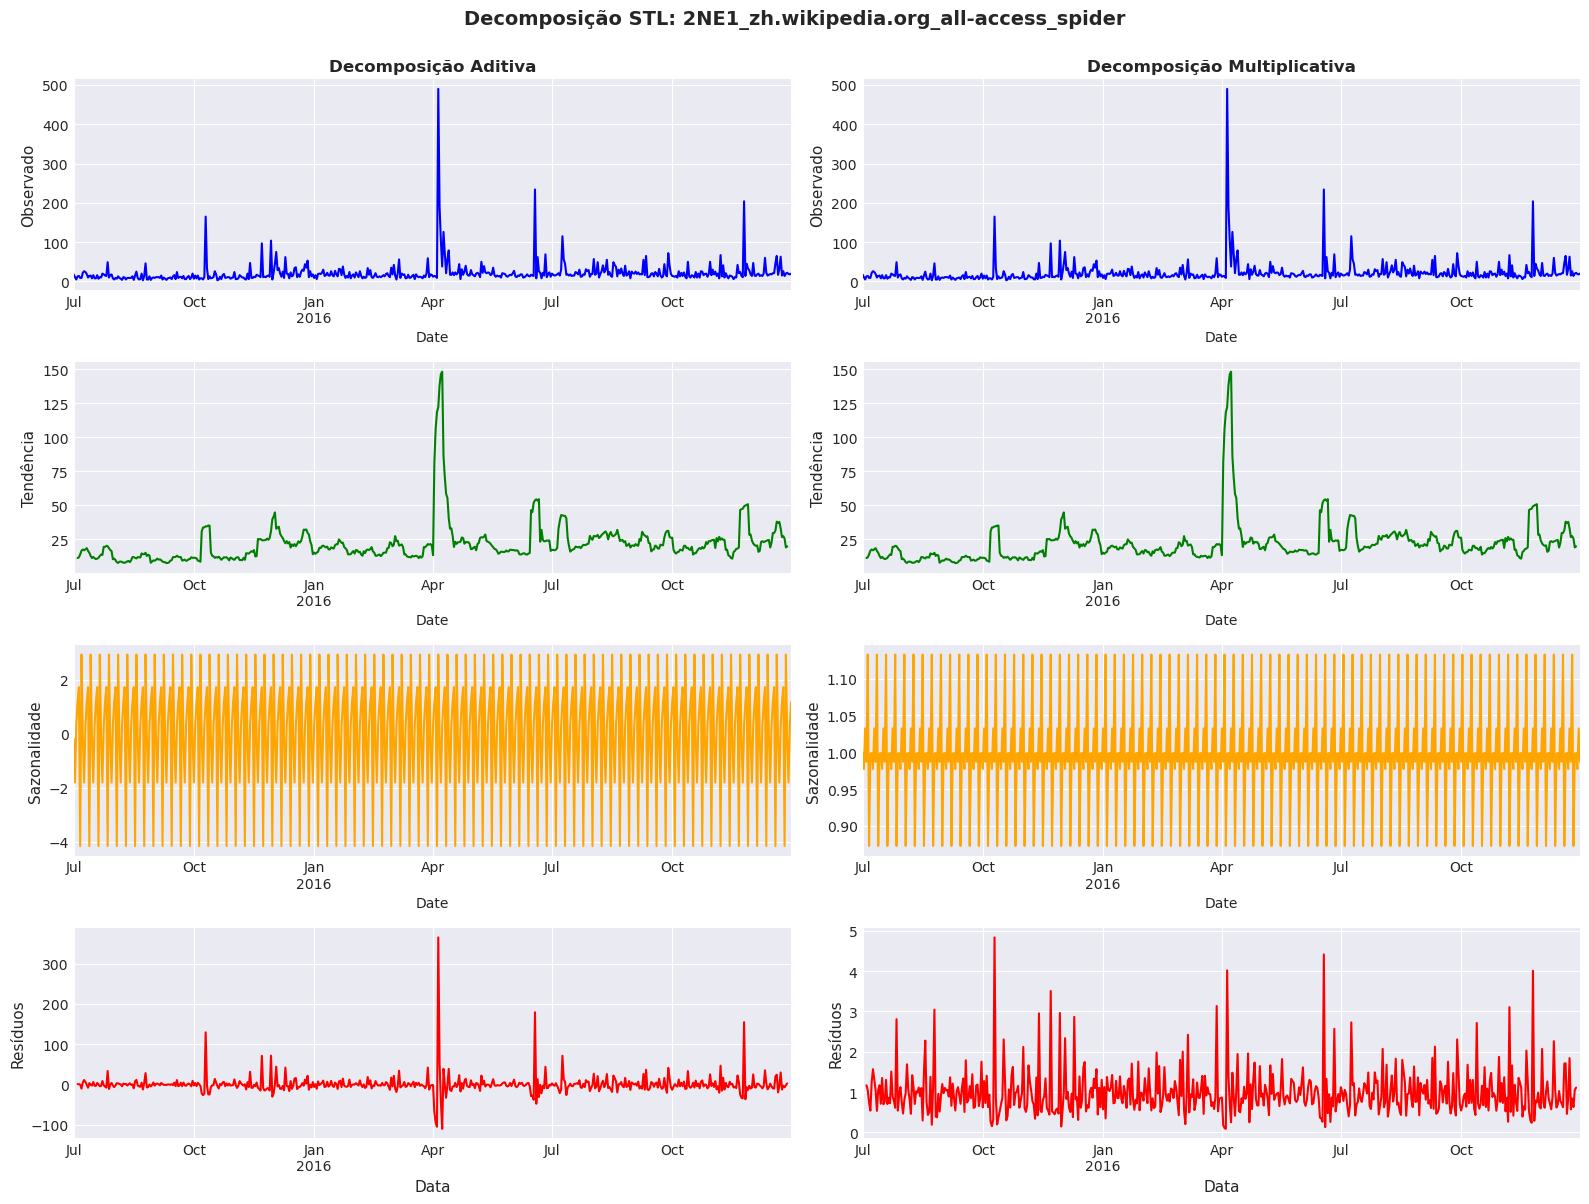


Força da sazonalidade:
  Modelo Aditivo: 0.0077

DECOMPOSIÇÃO: 2PM_zh.wikipedia.org_all-access_spider


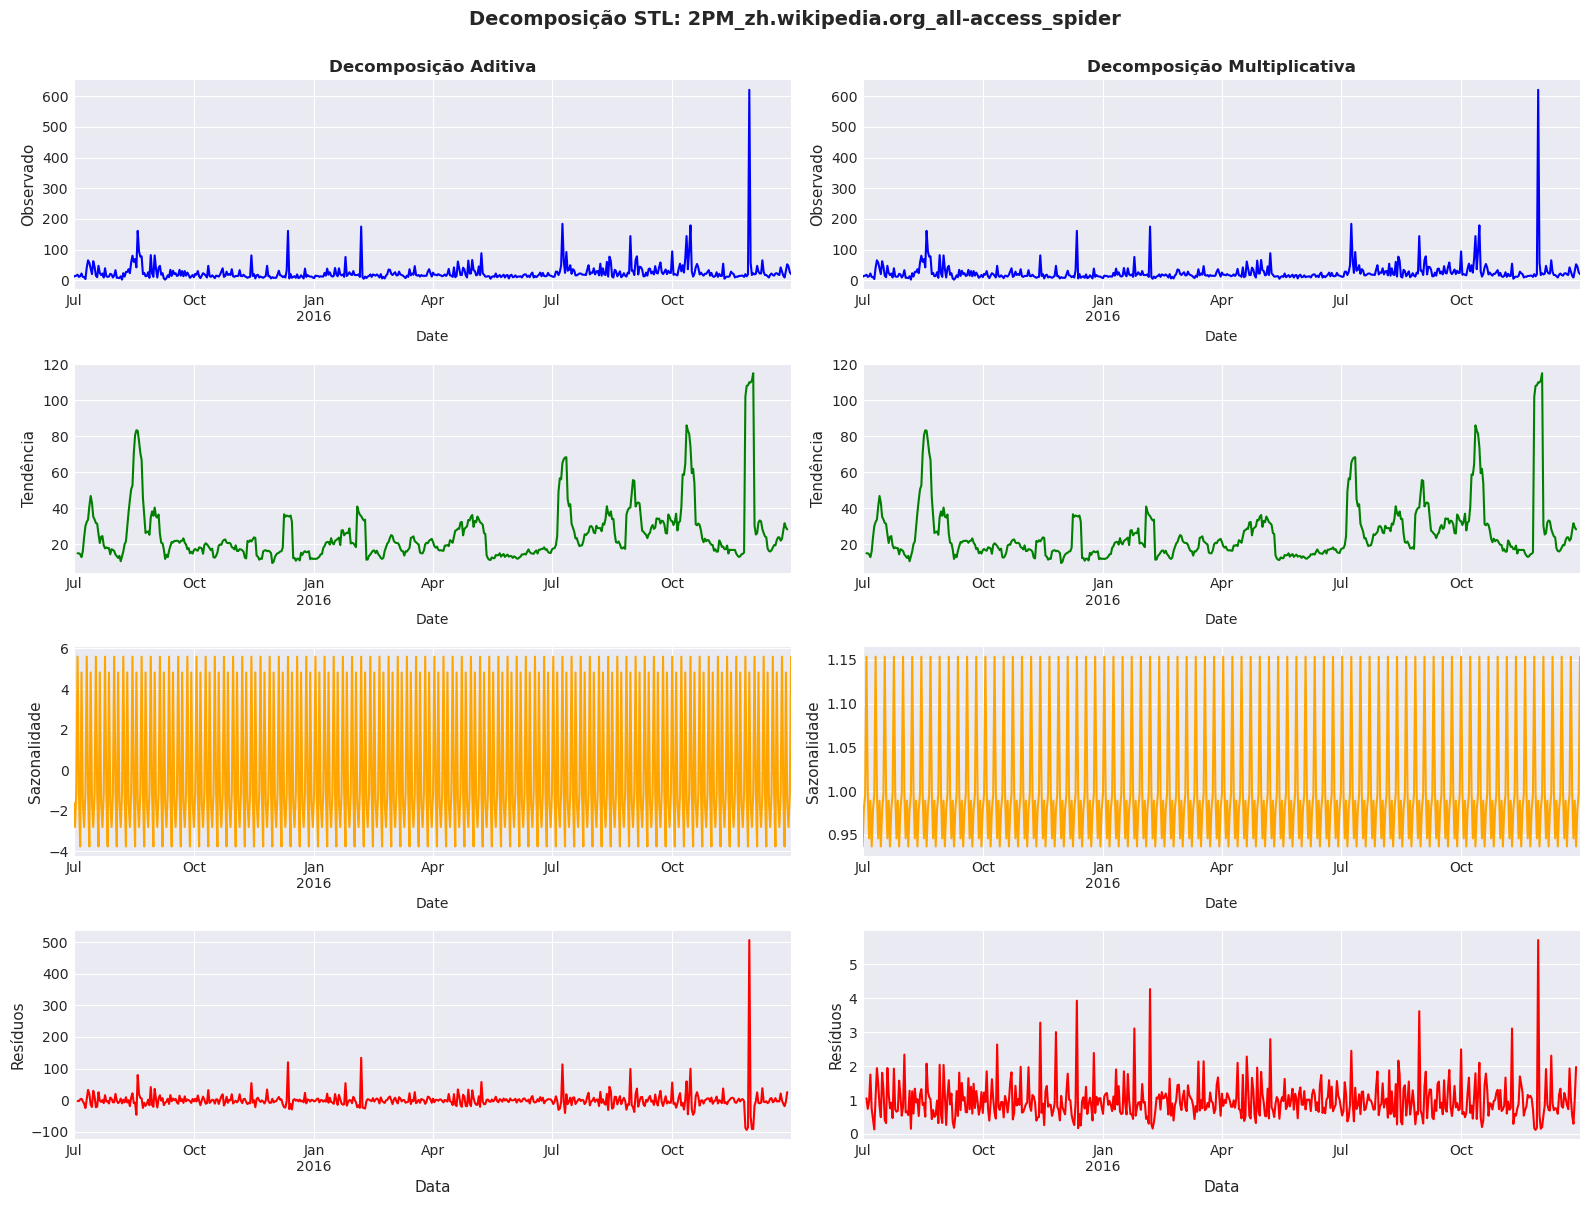


Força da sazonalidade:
  Modelo Aditivo: 0.0132


In [16]:
# Decomposição para cada página (exemplo com primeira página)
from statsmodels.tsa.seasonal import seasonal_decompose

for page in df_melted['Page'].unique()[:2]:  # Mostrar para primeiras 2 páginas
    print(f"\n{'='*60}")
    print(f"DECOMPOSIÇÃO: {page}")
    print(f"{'='*60}")
    
    page_data = df_melted[df_melted['Page'] == page].sort_values('Date').copy()
    page_data = page_data.set_index('Date')
    
    # Preencher valores ausentes para decomposição
    page_data['Views_filled'] = page_data['Views'].interpolate(method='linear')
    
    # Decomposição aditiva e multiplicativa
    try:
        decomposition_add = seasonal_decompose(page_data['Views_filled'], 
                                               model='additive', period=7)
        decomposition_mult = seasonal_decompose(page_data['Views_filled'], 
                                                model='multiplicative', period=7)
        
        fig, axes = plt.subplots(4, 2, figsize=(16, 12))
        
        # Modelo Aditivo
        decomposition_add.observed.plot(ax=axes[0, 0], color='blue')
        axes[0, 0].set_ylabel('Observado', fontsize=11)
        axes[0, 0].set_title('Decomposição Aditiva', fontsize=12, fontweight='bold')
        
        decomposition_add.trend.plot(ax=axes[1, 0], color='green')
        axes[1, 0].set_ylabel('Tendência', fontsize=11)
        
        decomposition_add.seasonal.plot(ax=axes[2, 0], color='orange')
        axes[2, 0].set_ylabel('Sazonalidade', fontsize=11)
        
        decomposition_add.resid.plot(ax=axes[3, 0], color='red')
        axes[3, 0].set_ylabel('Resíduos', fontsize=11)
        axes[3, 0].set_xlabel('Data', fontsize=11)
        
        # Modelo Multiplicativo
        decomposition_mult.observed.plot(ax=axes[0, 1], color='blue')
        axes[0, 1].set_ylabel('Observado', fontsize=11)
        axes[0, 1].set_title('Decomposição Multiplicativa', fontsize=12, fontweight='bold')
        
        decomposition_mult.trend.plot(ax=axes[1, 1], color='green')
        axes[1, 1].set_ylabel('Tendência', fontsize=11)
        
        decomposition_mult.seasonal.plot(ax=axes[2, 1], color='orange')
        axes[2, 1].set_ylabel('Sazonalidade', fontsize=11)
        
        decomposition_mult.resid.plot(ax=axes[3, 1], color='red')
        axes[3, 1].set_ylabel('Resíduos', fontsize=11)
        axes[3, 1].set_xlabel('Data', fontsize=11)
        
        plt.suptitle(f'Decomposição STL: {page[:50]}', fontsize=14, fontweight='bold', y=1.00)
        plt.tight_layout()
        plt.show()
        
        # Estatísticas dos componentes
        print("\nForça da sazonalidade:")
        seasonal_strength_add = 1 - (decomposition_add.resid.var() / 
                                     (decomposition_add.resid + decomposition_add.seasonal).var())
        print(f"  Modelo Aditivo: {seasonal_strength_add:.4f}")
        
    except Exception as e:
        print(f"Erro na decomposição: {e}")

## 7. Análise de Autocorrelação

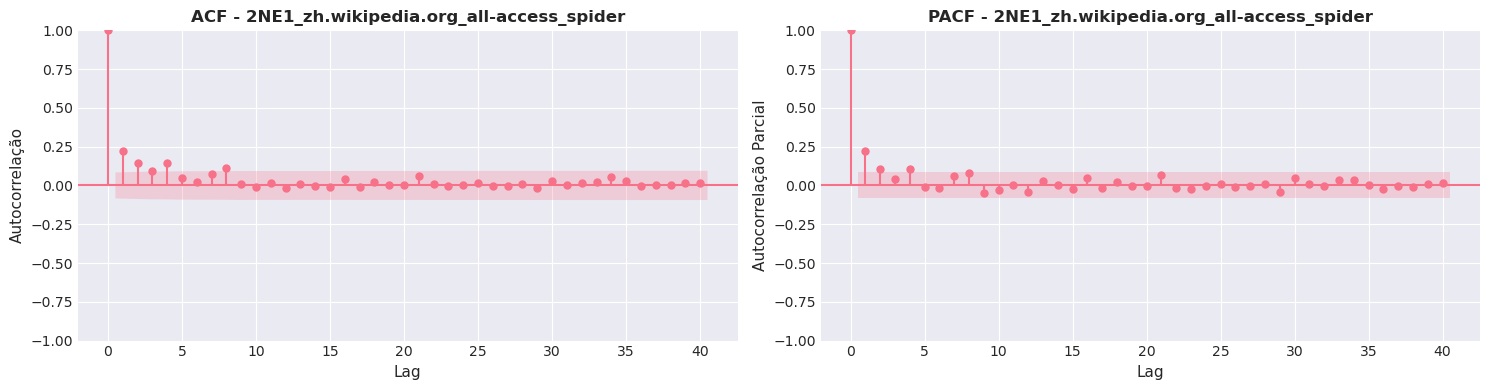

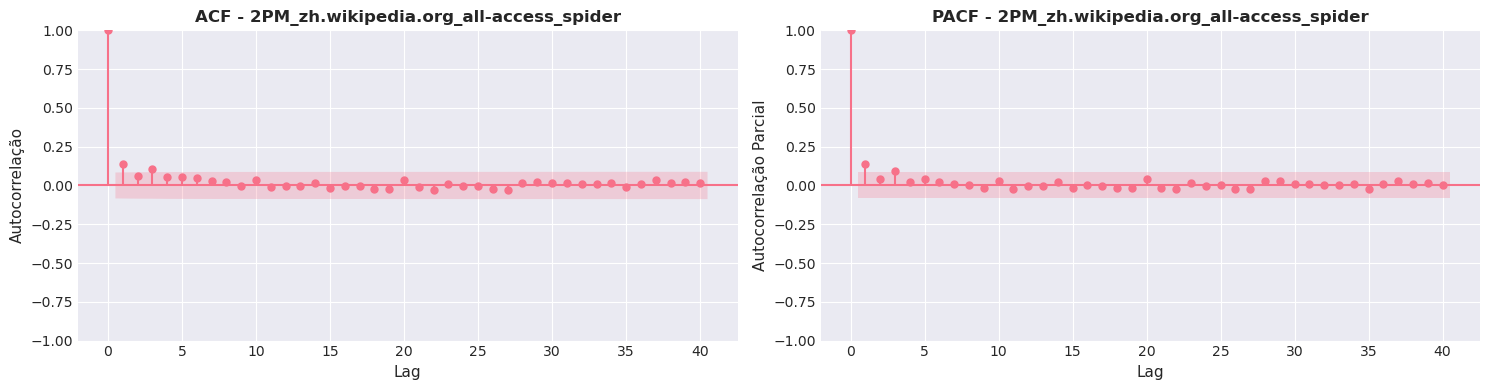

In [17]:
# ACF e PACF para cada página
for page in df_melted['Page'].unique()[:2]:  # Primeiras 2 páginas
    page_data = df_melted[df_melted['Page'] == page].sort_values('Date')['Views'].dropna()
    
    if len(page_data) > 50:  # Apenas se houver dados suficientes
        fig, axes = plt.subplots(1, 2, figsize=(15, 4))
        
        plot_acf(page_data, lags=40, ax=axes[0])
        axes[0].set_title(f'ACF - {page[:40]}', fontsize=12, fontweight='bold')
        axes[0].set_xlabel('Lag', fontsize=11)
        axes[0].set_ylabel('Autocorrelação', fontsize=11)
        
        plot_pacf(page_data, lags=40, ax=axes[1], method='ywm')
        axes[1].set_title(f'PACF - {page[:40]}', fontsize=12, fontweight='bold')
        axes[1].set_xlabel('Lag', fontsize=11)
        axes[1].set_ylabel('Autocorrelação Parcial', fontsize=11)
        
        plt.tight_layout()
        plt.show()

## 8. Resumo da Análise Exploratória

In [18]:
# Criar relatório resumido
print("="*70)
print("RESUMO DA ANÁLISE EXPLORATÓRIA")
print("="*70)

print("\n1. CARACTERÍSTICAS DO DATASET:")
print(f"   - Período: {df_melted['Date'].min().date()} a {df_melted['Date'].max().date()}")
print(f"   - Total de dias: {df_melted['Date'].nunique()}")
print(f"   - Número de páginas: {df_melted['Page'].nunique()}")
print(f"   - Total de observações: {len(df_melted):,}")
print(f"   - Valores ausentes: {df_melted['Views'].isnull().sum()} ({df_melted['Views'].isnull().sum()/len(df_melted)*100:.2f}%)")

print("\n2. ESTATÍSTICAS DAS VISUALIZAÇÕES:")
print(f"   - Média geral: {df_melted['Views'].mean():.2f}")
print(f"   - Mediana: {df_melted['Views'].median():.2f}")
print(f"   - Desvio padrão: {df_melted['Views'].std():.2f}")
print(f"   - Mínimo: {df_melted['Views'].min():.2f}")
print(f"   - Máximo: {df_melted['Views'].max():.2f}")

print("\n3. OUTLIERS:")
print(f"   - Quantidade: {len(outliers)} ({len(outliers)/len(df_melted)*100:.2f}%)")
print(f"   - Limites IQR: [{lower:.2f}, {upper:.2f}]")

print("\n4. PADRÕES TEMPORAIS IDENTIFICADOS:")
print(f"   - Sazonalidade semanal: {'SIM' if weekly_pattern.std() > 0 else 'NÃO'}")
print(f"   - Variação média semanal: {weekly_pattern.std():.2f}")
print(f"   - Dia com mais visualizações: {weekly_pattern.idxmax()}")
print(f"   - Dia com menos visualizações: {weekly_pattern.idxmin()}")

print("\n5. DISTRIBUIÇÃO DOS DADOS:")
print(f"   - Assimetria (skewness): {df_melted['Views'].skew():.4f}")
print(f"   - Curtose: {df_melted['Views'].kurtosis():.4f}")
print(f"   - Distribuição: {'Assimétrica à direita' if df_melted['Views'].skew() > 0 else 'Assimétrica à esquerda'}")

print("\n" + "="*70)
print("PRÓXIMOS PASSOS: Etapa 2 - Preparação e Tratamento dos Dados")
print("="*70)

RESUMO DA ANÁLISE EXPLORATÓRIA

1. CARACTERÍSTICAS DO DATASET:
   - Período: 2015-07-01 a 2016-12-31
   - Total de dias: 550
   - Número de páginas: 9
   - Total de observações: 4,950
   - Valores ausentes: 656 (13.25%)

2. ESTATÍSTICAS DAS VISUALIZAÇÕES:
   - Média geral: 23.31
   - Mediana: 15.00
   - Desvio padrão: 31.14
   - Mínimo: 0.00
   - Máximo: 621.00

3. OUTLIERS:
   - Quantidade: 339 (6.85%)
   - Limites IQR: [-20.50, 55.50]

4. PADRÕES TEMPORAIS IDENTIFICADOS:
   - Sazonalidade semanal: SIM
   - Variação média semanal: 1.74
   - Dia com mais visualizações: Saturday
   - Dia com menos visualizações: Thursday

5. DISTRIBUIÇÃO DOS DADOS:
   - Assimetria (skewness): 6.2445
   - Curtose: 73.6951
   - Distribuição: Assimétrica à direita

PRÓXIMOS PASSOS: Etapa 2 - Preparação e Tratamento dos Dados


In [19]:
# Salvar dados processados para próxima etapa
df_melted.to_csv('dados_explorados.csv', index=False)
print("\n✓ Dados explorados salvos em: dados_explorados.csv")


✓ Dados explorados salvos em: dados_explorados.csv
